In [ ]:
#pip install torch

In [ ]:
import torch as th
from torch import nn
import numpy as np
import random
from torch.optim import Adam
from tqdm import tqdm

#сделаем инициализацию random seed, 
#чтобы наши эксперименты были воспроизводимы

random.seed(0)
np.random.seed(0)
th.manual_seed(0)
th.cuda.manual_seed(0)
th.backends.cudnn.deterministic=True

In [ ]:
#скачивание датасета для классификации изображений
import torchvision.datasets

MNIST_train = torchvision.datasets.MNIST('./', download = True, train = True)
MNIST_test = torchvision.datasets.MNIST('./', download = True, train = False)

In [ ]:
X_train = MNIST_train.train_data
y_train = MNIST_train.train_labels
X_test = MNIST_test.test_data
y_test = MNIST_test.test_labels

/usr/local/lib/python3.8/dist-packages/torchvision/datasets/mnist.py:75: UserWarning: train_data has been renamed data
  warnings.warn("train_data has been renamed data")
/usr/local/lib/python3.8/dist-packages/torchvision/datasets/mnist.py:65: UserWarning: train_labels has been renamed targets
  warnings.warn("train_labels has been renamed targets")
/usr/local/lib/python3.8/dist-packages/torchvision/datasets/mnist.py:80: UserWarning: test_data has been renamed data
  warnings.warn("test_data has been renamed data")
/usr/local/lib/python3.8/dist-packages/torchvision/datasets/mnist.py:70: UserWarning: test_labels has been renamed targets
  warnings.warn("test_labels has been renamed targets")


In [ ]:
#посмотрим какой у данных тип
X_train.dtype, y_train.dtype

(torch.uint8, torch.int64)

In [ ]:
#данные имеют тип беззнаковый 8, а таргеты - целые 64 бита
#преобразуем сразу данные в веществиенный тип
X_train = X_train.float()
X_test = X_test.float()

In [ ]:
#посмотрим на расзмерность датасетов
X_train.shape, X_test.shape
#это очень маленькие картинки, именно поэтому мы можем использовать
#полносвязную нейронную сеть для такой задачи, а не сверточные сети

(torch.Size([60000, 28, 28]), torch.Size([10000, 28, 28]))

In [ ]:
y_train.shape, y_test.shape

(torch.Size([60000]), torch.Size([10000]))

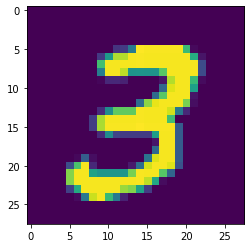

tensor(3)


In [ ]:
#посмотрим на картинки
import matplotlib.pyplot as plt
plt.imshow(X_train[7, :, :])
plt.show()
print(y_train[7])

In [ ]:
#у нас трезмерный тензор, мы хотим двумерный тензор, 
#чтобы первая рамерность сохранилась, то есть 60000 картинок
#вместо 28 и 28 будет 764 пикселя

X_train = X_train.reshape([-1, 28*28])
X_test = X_test.reshape([-1, 28*28])

print(X_train)


tensor([[0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.],
        ...,
        [0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.]])


# Моя работа

###Задание


1.   Дописать код после фразы Ваш_Код_Здесь.
2.   Поэкспериментировать с гиперпараметрами нейронной сети, чтобы добиться более высокой точности классификации.
4.   Построить на одном графике loss для тестовой выборки и для обучающей.
5.   Ведет ли увеличение количества эпох (40 эпох -> 200 эпох) к улучшению метрик на валидации?
6.   Замерьте время вычисления 100 эпох на CPU и на GPU.
7.   Показать результат работы модели с использованием функции predict.


In [ ]:
#Создание сети
# на выходе у нас числа от 0 до 9
class MNISTnet(th.nn.Module):
  def __init__(self):
    super (MNISTnet, self).__init__()
    self.fc1 = nn.Linear(784, 256)
    self.ac1 = nn.ReLU()
    self.fc2 = nn.Linear(256, 128)
    self.ac2 = nn.ReLU()
    self.fc3 = nn.Linear(128, 10)
    self.sm = nn.Softmax(dim = 1)
   
  def forward(self, x):
    x = self.fc1(x)
    x = self.ac1(x)
    x = self.fc2(x)
    x = self.ac2(x)
    x = self.fc3(x)
    return x


  
  def predict(self,x):
    x=self.forward(x)
    x=self.sm(x)
    return x


In [ ]:
''' есть ли видеокарта?'''
th.cuda.is_available()

True

In [ ]:
'''смотрим, занята ли карта какими либо вычислениями'''
!nvidia-smi

Sun Feb 12 20:15:39 2023       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 510.47.03    Driver Version: 510.47.03    CUDA Version: 11.6     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla T4            Off  | 00000000:00:04.0 Off |                    0 |
| N/A   59C    P0    26W /  70W |      3MiB / 15360MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [ ]:
""" теперь нужно переложить вычисления на видеокарту"""

device = th.device('cuda:0' if th.cuda.is_available() else 'cpu')
#net = net.to(device)

## Main

In [ ]:
fc_net = MNISTnet().to(device)

In [ ]:
#лосс функция
loss_function = nn.CrossEntropyLoss()

#оптимизатор
optimizer = Adam(fc_net.parameters(), lr = 0.001)

In [ ]:
batch_size = 1000
epochs = 10

'''перекладываем входные данные теста на видеокарту'''
X_test = X_test.to(device)
y_test = y_test.to(device)

X_train = X_train.to(device)
y_train = y_train.to(device)

train_losses = []
test_losses = []

'''данные тренировочной выборки будем перекладывать на cuda по батчам'''
for epoch in tqdm(range(epochs)):
  order = np.random.permutation(len(X_train))
  for start_index in range (0,len(X_train), batch_size):

    fc_net.train() # перевод в режим train

    optimizer.zero_grad() # обнуляем градиенты

    batch_index = order[start_index:start_index+batch_size] # выделение батча из датасета
    X_batch = X_train[batch_index] #
    y_batch = y_train[batch_index] #

    preds = fc_net.forward(X_batch) # предсказание на батче
    loss_val = loss_function(preds, y_batch) # лосс на батче
    train_losses.append(loss_val) # сохраняем лосс на трейне

    loss_val.backward() # расчет градиентов
    optimizer.step() # шаг градиента + оптимизатора
    
    with th.no_grad():
        loss_test = loss_function(fc_net.forward(X_test), y_test) # лосс на тесте
        test_losses.append(loss_test) # сохраняем лосс на тесте


100%|██████████| 10/10 [00:02<00:00,  3.53it/s]


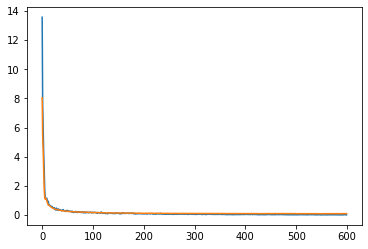

In [ ]:
train_losses_list = [i.to('cpu').tolist() for i in train_losses]
plt.plot(range(len(train_losses_list)), train_losses_list)
test_losses_list = [i.to('cpu').tolist() for i in test_losses]
plt.plot(range(len(test_losses_list)), test_losses_list)

увеличение количества эпох не всегда дает хороший результат

In [ ]:
from sklearn.metrics import f1_score

In [ ]:
f1_score(fc_net.predict(X_test).to('cpu').argmax(dim = 1).tolist(), y_test.tolist(), average = 'weighted')

0.9722945705765598

## Тест на время

In [ ]:
cpu_model = MNISTnet().to('cpu')

cpu_loss_function = nn.CrossEntropyLoss()

cpu_optimizer = Adam(cpu_model.parameters())

In [ ]:
def model_fit(model, batch_size, epochs, X_test, y_test, X_train, y_train, device, loss_function, optimizer):

    '''перекладываем входные данные теста на видеокарту'''

    
    #return : train_losses, test_losses
    
    X_test = X_test.to(device)
    y_test = y_test.to(device)

    X_train = X_train.to(device)
    y_train = y_train.to(device)

    #train_losses = []
    #test_losses = []

    '''данные тренировочной выборки будем перекладывать на cuda по батчам'''
    for epoch in tqdm(range(epochs)):
      order = np.random.permutation(len(X_train))
      for start_index in range (0,len(X_train), batch_size):

        model.train() # перевод в режим train

        optimizer.zero_grad() # обнуляем градиенты

        batch_index = order[start_index:start_index+batch_size] # выделение батча из датасета
        X_batch = X_train[batch_index] #
        y_batch = y_train[batch_index] #

        preds = model.forward(X_batch) # предсказание на батче
        loss_val = loss_function(preds, y_batch) # лосс на батче
        #train_losses.append(loss_val) # сохраняем лосс на трейне

        loss_val.backward() # расчет градиентов
        optimizer.step() # шаг градиента + оптимизатора
        
        #with th.no_grad():
            #loss_test = loss_function(model.forward(X_test), y_test) # лосс на тесте
            #test_losses.append(loss_test) # сохраняем лосс на тесте
    #return train_losses, test_losses

### обучение на cpu

In [ ]:
cpu_model = MNISTnet().to('cpu')

cpu_loss_function = nn.CrossEntropyLoss()

cpu_optimizer = Adam(cpu_model.parameters())
###
model_fit(model = cpu_model,
          batch_size = 1000,
          epochs = 100,
          X_test = X_test,
          y_test = y_test,
          X_train = X_train,
          y_train = y_train,
          device = 'cpu',
          loss_function = cpu_loss_function,
          optimizer = cpu_optimizer)

100%|██████████| 100/100 [02:04<00:00,  1.24s/it]


### обучение на gpu

In [ ]:
gpu_model = MNISTnet().to('cuda:0')

gpu_loss_function = nn.CrossEntropyLoss()

gpu_optimizer = Adam(cpu_model.parameters())
###
model_fit(model = gpu_model,
          batch_size = 1000,
          epochs = 100,
          X_test = X_test,
          y_test = y_test,
          X_train = X_train,
          y_train = y_train,
          device = 'cuda:0',
          loss_function = gpu_loss_function,
          optimizer = gpu_optimizer)

100%|██████████| 100/100 [00:24<00:00,  4.06it/s]


Время на 100 эпохах при batch_size = 1000 на cpu ~ 2 минуты

Время на 100 эпохах при batch_size = 1000 на gpu ~ 24 секунды